<a href="https://colab.research.google.com/github/htapiagroup/sistdist/blob/master/MCA_SDU2_S6L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas Distribuidos y Ubicuos II
## MCA Tercer cuatrimestre
### Horacio Tapia-McClung

## Resumen Semana 5

* arreglos multidimensionales con `numpy` y `dask`
* DataFrames con `pandas` y `dask`

* leyendo multiples archivos de texto (.csv)
* construyendo flujos retrasados
* cronometraje de operaciones con dataframes, `pandas` vs. `dask`

Cuando usar `pandas` y cuando usar `dask`?

In [0]:
import os
plantilla = 'yellow_tripdata_2018-{:02d}.csv'
plantillaURL = 'wget https://s3.amazonaws.com/nyc-tlc/trip+data/'+plantilla
urls = (plantillaURL.format(k) for k in range(1,3)) # generator
for url in urls:
  os.system(url)

In [8]:
ls

sample_data/                 yellow_tripdata_2018-01.csv.1
yellow_tripdata_2018-01.csv  yellow_tripdata_2018-02.csv


In [0]:
import pandas as pd

## Flujo de analisis usando `pandas`

In [3]:
df = pd.read_csv('yellow_tripdata_2018-01.csv')
df.shape

(8759874, 17)

In [4]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [7]:
df['payment_type'].value_counts()

1    6105871
2    2598947
3      43204
4      11852
Name: payment_type, dtype: int64

Calcular la fraccion del monto total del viaje que corresponde a la propina:

$f_p = \frac{propina}{total-propina}$

In [0]:
df['tip_fraction'] = df['tip_amount']/(df['total_amount'] - df['tip_amount'])

In [11]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'tip_fraction'],
      dtype='object')

In [0]:
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

In [0]:
df['hour']=df['tpep_dropoff_datetime'].dt.hour

In [15]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'tip_fraction', 'hour'],
      dtype='object')

In [0]:
credito = df[df.payment_type==1]

In [17]:
credito.shape

(6105871, 19)

In [0]:
porHora = credito.groupby('hour')

In [0]:
resultado = porHora['tip_fraction'].mean()

In [23]:
resultado.shape

(24,)

In [0]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Fraccion de propinas')

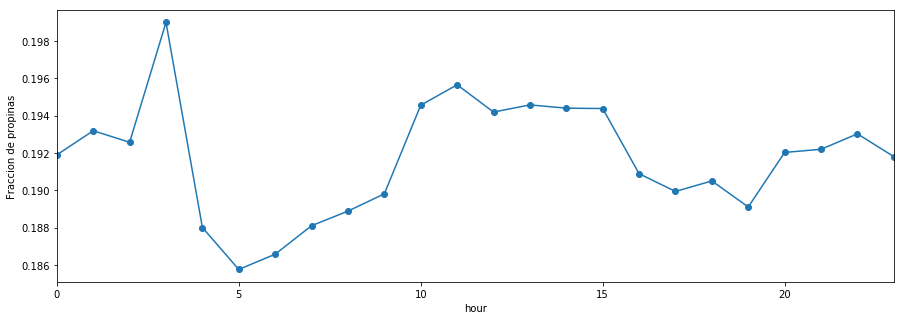

In [28]:
resultado.plot.line(style="-o", figsize=(15,5))
plt.ylabel("Fraccion de propinas")

In [0]:
porHoras = df.groupby('hour')
numPasajerosPorHora = porHoras['passenger_count'].mean()

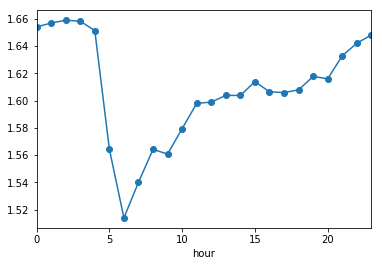

In [33]:
numPasajerosPorHora.plot.line(style="-o")

Como agreagriamos por dia?

In [0]:
df['weekday'] = df['tpep_dropoff_datetime'].dt.weekday

In [0]:
weekDayPU = df.groupby('weekday')
weekDayPUCount = weekDayPU['passenger_count'].mean()


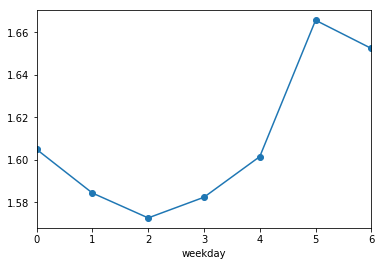

In [43]:
weekDayPUCount.plot.line(style="-o")

## Reproducimos el ejercicio de la fraccion de propina usando `dask`

In [0]:
import dask.dataframe as dd

# leer todos los archivos de datos

df = dd.read_csv("yellow_tripdata_2018-*.csv", assume_missing=True)

In [0]:
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

In [0]:
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

In [0]:
df.hour

In [51]:
credito = df[df.payment_type==1]

hour = credito.groupby('hour')

resultado = hour['tip_fraction'].mean()

type(resultado)



dask.dataframe.core.Series

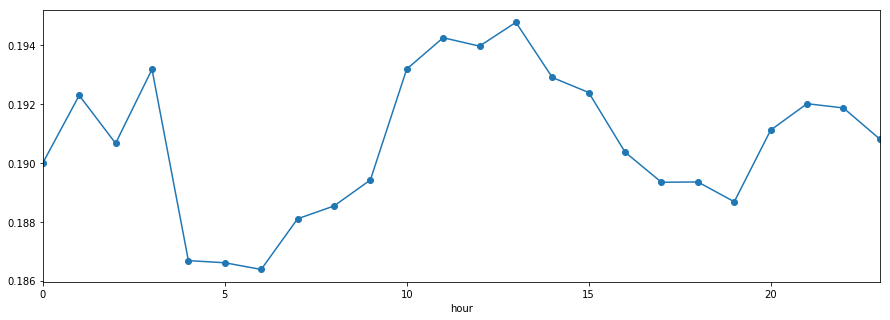

In [53]:
tip_frac = resultado.compute()
tip_frac.plot.line(style="-o", figsize=(15,5))

## Una base de datos alternativa a los viajes en taxi

In [0]:
!wget http://s3.amazonaws.com/datashader-data/nyc_taxi.zip && unzip nyc_taxi.zip

In [59]:
%time df = pd.read_csv('nyc_taxi.csv', usecols=['dropoff_x', 'dropoff_y'] )
df.tail()

CPU times: user 12.9 s, sys: 917 ms, total: 13.8 s
Wall time: 13.8 s


,dropoff_x,dropoff_y
10679302,-8.232492e+06,4.979234e+06
10679303,-8.234857e+06,4.971131e+06
10679304,-8.234203e+06,4.981092e+06
10679305,-8.235618e+06,4.973722e+06
10679306,-8.234152e+06,4.977120e+06


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10679307 entries, 0 to 10679306
Data columns (total 2 columns):
dropoff_x    float64
dropoff_y    float64
dtypes: float64(2)
memory usage: 163.0 MB


In [0]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show



In [0]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [66]:
from bokeh.tile_providers import STAMEN_TERRAIN

output_notebook()
muestras = df.sample(n=10000)
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=muestras['dropoff_x'], y = muestras['dropoff_y'], **options)
show(p)

Loading BokehJS ...